# Lifelines Survival Modeling Getting Started

This notebook shows you how to get started using the Lifelines package to create a Survival model. Implementing and validating the model is left as an exercise for the hacker.

<img src="http://i.imgur.com/EOowdSD.png"/>

# 0. Library Versions

The Azure Notebooks interface defaults to an older version of Pandas where a bug is present in the read_excel function, so we need to upgrade our Pandas version first. Ensure that after you've run the upgrade, you see version 0.23.4 and 1.1.0 for pandas and xlrd, respectively. Additionally, we'll manually install the Lifelines package in Python.

In [1]:
!pip install --upgrade pandas
!pip install lifelines
!pip install seaborn

Requirement already up-to-date: pandas in /Users/hussainbharmal/anaconda3/lib/python3.6/site-packages (0.24.1)
You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 307kB 6.9MB/s ta 0:00:01
    100% |████████████████████████████████| 829kB 1.9MB/s ta 0:00:011
  Stored in directory: /Users/hussainbharmal/Library/Caches/pip/wheels/72/6f/c2/40f130cca2c91f31d354bf72de282922479c09ce0b7853c4c5
  Stored in directory: /Users/hussainbharmal/Library/Caches/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built autograd future
You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## 1. Data Flexing

First, we'll extract our data and get it into the format that the model prefers. The model requires each row to contain the variables of iterest, a unique identifier, a start and stop temporal label (for the beginning and the end of the time captured by the row), and an event label (which should only be 1 on the row with which the event was associated, not for all rows whose ID eventually have that event occur).

We load data from the Treatment Analysis notebook and generate a table with the measured variables as well as some critical demographic variables. For convenience and parity to the lifelines documentation, we rename several columns to the names associated with that documentation.

In [2]:
import numpy as np
import pickle as pkl
import pandas as pd
import matplotlib.style
import matplotlib as mpl

mpl.style.use('dark_background')
with open('data.pkl', 'rb') as f:
    data = pkl.load(f)
with open('outcomes.pkl', 'rb') as f:
    outcomes_data = pkl.load(f)

original_data_count = len(data)

severity_metrics = ['Attitude', 'Paw Temperature', 'Vomiting', 'Gum Color', 'On Distemper Watch? (only mark on shift watch started)', 'Appetite', 'Feces', 'Drinking Water']
identifiers = ['Dog A#']
temporal_labels = ['Treatments Since Intake', 'Treatment Date', 'Treatment Shift']
outcomes = ['outcome']
time_series = data[identifiers + severity_metrics + temporal_labels + outcomes]
time_series['Treatment Shift'] = time_series['Treatment Shift'].replace(['AM', 'PM'], [0, 1])
#tmp = DatetimeIndex(['0000-00-00 12:00:00'], dtype='datetime64[ns]')
#print(tmp.head(1))
time_series['Treatment Date'] = time_series['Treatment Date'].add(time_series['Treatment Shift'].multiply(pd.to_timedelta(12, unit='h')))
time_series = time_series.drop('Treatment Shift', axis=1)

demo_metrics = ['Intake Weight (lbs)', 'Sex', 'Age at Intake (Weeks)']
demographics = outcomes_data[['Dog A#'] + demo_metrics].replace('Female', 0).replace('Male', 1).replace('Unknown', np.nan)

columns = np.array(time_series.columns)
columns[9] = 'stop'
columns[0] = 'id'
columns[11] = 'event'

time_series.columns = columns

# hack for time element
time_series['start'] = np.array(time_series['stop']) - 1

add = []
dates = []
shifts = []
for index, row in time_series.iterrows():
    add.append(np.array(demographics[demographics['Dog A#']==row['id']][demo_metrics])[0])
    
weights, genders, ages = np.transpose(add)

time_series['Intake Weight (lbs)'] = weights
time_series['Sex'] = genders
time_series['Age at Intake (Weeks)'] = ages

time_series = time_series.apply(pd.to_numeric)

for metric in time_series.columns:
    time_series = time_series[~np.isnan(time_series[metric])]

time_series_full = time_series.copy()
 
grp = time_series.groupby('id')
for name, group in grp:
    vals = np.array(group['event'])
    tmp = vals[0]
    vals = np.zeros(len(vals))
    vals[-1] = tmp
    time_series.loc[time_series['id'] == name, 'event'] = vals

/Users/hussainbharmal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hussainbharmal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Note that the values for dogs that die have an event==1 on their last time point as they died after that time point. Dogs that survive have all 0s in their event column.

In [3]:
from IPython.core import display as ICD

grp = time_series.groupby('id')
for name, group in grp:
    if np.array(group['event'])[-1] == 1.:
        ICD.display(group)
        break

,id,Attitude,Paw Temperature,Vomiting,Gum Color,On Distemper Watch? (only mark on shift watch started),Appetite,Feces,Drinking Water,stop,Treatment Date,event,start,Intake Weight (lbs),Sex,Age at Intake (Weeks)
248,46125,2.0,0.0,0.0,0.0,0,3.0,2.0,1.0,1,1485432000000000000,0.0,0,5.3,0.0,13.0
249,46125,2.0,0.0,0.0,0.0,0,3.0,3.0,1.0,2,1485475200000000000,0.0,1,5.3,0.0,13.0
250,46125,2.0,0.0,2.0,0.0,0,3.0,4.0,1.0,3,1485518400000000000,0.0,2,5.3,0.0,13.0
251,46125,2.0,0.0,1.0,0.0,0,3.0,2.0,1.0,4,1485561600000000000,0.0,3,5.3,0.0,13.0
252,46125,2.0,0.0,1.0,0.0,0,3.0,2.0,1.0,5,1485604800000000000,0.0,4,5.3,0.0,13.0
253,46125,3.0,0.0,1.0,1.0,0,3.0,2.0,1.0,6,1485648000000000000,1.0,5,5.3,0.0,13.0


We've only elimiated a small portion of the data by allowing demographics to be included and enforcing no nan values.

In [4]:
eliminated_rows = original_data_count-len(time_series)
print('{0:.2f}% of (count={1}) rows eliminated due to nan values in demographics.'.format(
    (eliminated_rows)/original_data_count*100.,
    eliminated_rows))

time_series.drop(['Gum Color', 'On Distemper Watch? (only mark on shift watch started)', 'Drinking Water', 'Age at Intake (Weeks)'
                 , 'Sex', 'Intake Weight (lbs)'], axis=1, inplace=True)

0.94% of (count=80) rows eliminated due to nan values in demographics.


## 2. Simple Model Training

Next, we'll train the CoxTimeVaryingFitter with the data using a small step size to ensure convergence. This model accounts for the temporal element of the data, training using gradient descent to develop a predictive model which can determine the hazard level of an animal at different time points given their current history. The latest point in this hazard score can then be used to determine whether or not a special intervention is needed.

Note that the more data present in the model, the more accurately this model can predict which dogs will need special intervention.

In [5]:
from lifelines import CoxTimeVaryingFitter

mpl.style.use('default')

# Using Cox Proportional Hazards model
ctvf = CoxTimeVaryingFitter()
ctvf.fit(time_series.drop(['Treatment Date'], axis=1), id_col="id", event_col="event", start_col="start", stop_col="stop", step_size=0.1, show_progress=True)
ctvf.predict_partial_hazard(time_series)


Iteration 1: norm_delta = 0.24533, step_size = 0.10000, ll = -601.21560, newton_decrement = 419.83563, seconds_since_start = 0.1
Iteration 2: norm_delta = 0.09304, step_size = 0.10000, ll = -525.34417, newton_decrement = 89.55961, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.07833, step_size = 0.10000, ll = -508.35444, newton_decrement = 66.58319, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.08229, step_size = 0.12000, ll = -495.71335, newton_decrement = 51.78566, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.07100, step_size = 0.11760, ll = -484.03544, newton_decrement = 39.53636, seconds_since_start = 0.1
Iteration 6: norm_delta = 0.06299, step_size = 0.11525, ll = -475.28232, newton_decrement = 31.14384, seconds_since_start = 0.1
Iteration 7: norm_delta = 0.06970, step_size = 0.13830, ll = -468.51463, newton_decrement = 25.05707, seconds_since_start = 0.1
Iteration 8: norm_delta = 0.06283, step_size = 0.13553, ll = -462.05726, newton_decrement = 19.52753, s

,0
0,11.716225
2,5.061719
3,20.892709
4,13.728721
5,0.457468
6,0.457468
7,0.256681
8,0.197638
9,0.197638
10,0.225233


The above plot and table show the model coefficients, their significance (as measured by a difference from 0.0 in which the variable would not be used in the model), and their variability. Note that Attitude, Gum Color, Appetite, and Vomiting are highly significant predictors of hazard level, contributing significantly to the model. Additionally, Paw Temperature, Sex, and Intake Weight contribute to the model but to a lesser degree (although still significantly). The remaining variables to not significantly predict hazard level due their high variability.

In [6]:
# Attitude, Paw Temp, Vomiting, Apetite, Feces
coeffecients = ctvf.hazards_
means = [1.37834966, 0.0114508323, 0.12241766, 1.11911227, 1.66119703]

def subtractList(a, b):
    o = []
    for i in range(len(a)):
        o.append(a[i] - b[i]);
    return o

def predict(values):
    return math.exp(np.dot(np.array(subtractList(values, means)), np.array(coeffecients)))

final_dataset = time_series
final_dataset['Hazard'] = ctvf.predict_partial_hazard(time_series)
final_dataset
    


,id,Attitude,Paw Temperature,Vomiting,Appetite,Feces,stop,Treatment Date,event,start,Hazard
0,48300,2.0,0.0,0.0,3.0,4.0,1,1493510400000000000,0.0,0,11.716225
2,45896,2.0,0.0,0.0,2.0,2.0,1,1484395200000000000,0.0,0,5.061719
3,45896,2.0,0.0,2.0,3.0,2.0,2,1484438400000000000,0.0,1,20.892709
4,45896,2.0,0.0,1.0,3.0,2.0,3,1484481600000000000,0.0,2,13.728721
5,45896,1.0,0.0,0.0,1.0,2.0,4,1484524800000000000,0.0,3,0.457468
6,45896,1.0,0.0,0.0,1.0,2.0,5,1484568000000000000,0.0,4,0.457468
7,45896,1.0,0.0,0.0,0.0,2.0,6,1484611200000000000,0.0,5,0.256681
8,45896,1.0,0.0,0.0,0.0,0.0,7,1484654400000000000,0.0,6,0.197638
9,45896,1.0,0.0,0.0,0.0,0.0,8,1484697600000000000,0.0,7,0.197638
10,45926,1.0,0.0,0.0,0.0,1.0,1,1487937600000000000,0.0,0,0.225233


## 3. Next Steps

Now you have what you need to proceed with creating better predictive models, visualizations, and risk assessments. Play around and have fun! Remember, the overall goal for this exploration is to provide information which can help identify puppies for whom our current life-saving treatments will fail, so that the Veterinarians can attempt experimental treatments to save their lives.

In [7]:
from sklearn.neighbors import KNeighborsClassifier

# keep most recent features 
time_series.drop_duplicates(subset='id', keep='last', inplace=True)
outcomes_data.rename(columns={'Dog A#': 'id'}, inplace=True)
final_data = pd.merge(time_series, outcomes_data, on='id')
final_data.columns

final_data = final_data[['Hazard', 'Deceased']]

final_data
# removed: Days in ICU


,Hazard,Deceased
0,0.197638,No
1,0.256681,No
2,0.225233,No
3,0.256681,No
4,0.256681,No
5,0.225233,No
6,0.225233,No
7,0.256681,No
8,0.225233,No
9,0.225233,No


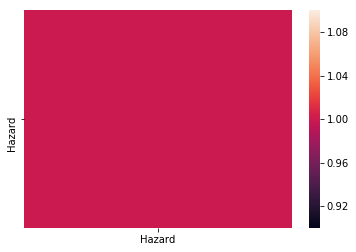

In [8]:
import seaborn as sns
%matplotlib inline
corr = final_data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

# basic cleaning and partioning 
final_data_X = pd.DataFrame(final_data['Hazard'])
final_data_Y = list(final_data['Deceased'])
for i in range(len(final_data_Y)):
    if final_data_Y[i] == 'Yes':
        final_data_Y[i] = 1
    elif final_data_Y[i] == 'No':
        final_data_Y[i] = 0
        
final_data_Y = pd.Series(final_data_Y)

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(final_data_X, final_data_Y, random_state=0)

clf = KNeighborsClassifier().fit(X_train, y_train)
clf.score(X_test, y_test)

0.9415204678362573

In [10]:
from sklearn.dummy import DummyClassifier 

# Negative class (0) is most frequent
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
# Therefore the dummy 'most_frequent' classifier always predicts class 0
dummy_majority.score(X_test, y_test)

0.8713450292397661